## Ex 5

In [ ]:
import site
import sys

# Make sure user path to venv site-packages is in system path
user_site = site.getusersitepackages()
if user_site not in sys.path:
    sys.path.append(user_site)

# Install tcsc-rl package from acc-py python index
!pip install --user tcsc-rl --index-url https://acc-py-repo.cern.ch/repository/vr-py-releases/simple --trusted-host acc-py-repo.cern.ch
!pip install --user stable-baselines3

### Define gymnasium environment for the AWAKE machine

It's important to introduce state, action, and reward scales to ensure that their absolute values are close to 1. This is because the underlying function approximators are neural nets that work best with normalized inputs.

In [2]:
import gymnasium as gym
import numpy as np

from tcsc_rl.awake.awake_h_steering_tcsc import AwakeHTrajectory


class AwakeEnv(gym.Env):
    # Define the action, state and reward scales
    # This is very important for the RL algorithm to work properly
    state_scale: float = 100  # to bring states to ~ [-1, 1]
    action_scale: float = 300e-6  # to bring actions to [-1, 1]
    reward_scale: float = 100.0  # to bring rewards from m to cm
    reward_threshold = -0.15  # units of cm

    # Criterion to truncate an episode (i.e. even if unsolved)
    n_steps_max = 50

    def __init__(self):
        """Initialise Awake beam line environment with 10 correctors
        and 10 BPMs, following the Farama gymnasium interface."""
        super().__init__()
        self.awake_machine = AwakeHTrajectory()
        self.action_space = gym.spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self.awake_machine.n_correctors,),
            dtype=np.float32,
        )
        self.observation_space = gym.spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self.awake_machine.n_bpms,),
            dtype=np.float32,
        )

        self.step_count = 0
        self.initial_reward_log = []
        self.final_reward_log = []
        self.episode_len_log = []

    def calculate_reward(self, trajectory):
        """Calculate the reward based on the trajectory in units of cm."""
        return -self.reward_scale * np.sqrt(np.mean(trajectory**2))

    def reset(self, seed=None, options=None):
        """Reset the environment to random initial corrector settings
        and return the initial state (scaled)."""
        super().reset(seed=seed)
        self.step_count = 0
        init_traj = self.awake_machine.initalise_trajectory_random()
        reward = self.calculate_reward(init_traj)
        self.initial_reward_log.append(reward)
        return init_traj * self.state_scale, {}

    def step(self, action):
        """Take a step in the environment by applying the action proposed
        by the agent. Since the agent works in scaled action space, we need
        to unscale the action back to original bounds before applying it."""
        # Rescale action from normalized range [-1, 1] to original
        # range [-300 um, 300 um]
        scaled_action = action * self.action_scale

        # Apply the rescaled action to the environment
        new_traj = self.awake_machine.set_and_read_trajectory_relative(
            delta_k=scaled_action,
        )

        # Compute the reward and check for termination
        reward = self.calculate_reward(new_traj)
        done = reward > self.reward_threshold
        truncated = self.step_count >= self.n_steps_max

        if done or truncated:
            self.final_reward_log.append(reward)
            self.episode_len_log.append(self.step_count)

        self.step_count += 1

        # Ensure that you return the scaled state as agent works in
        # normalized space.
        return new_traj * self.state_scale, reward, done, truncated, {}

### Run a TD3 agent

*using stable-baselines3*

In [ ]:
from matplotlib import pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise

env = AwakeEnv()

# It's helpful to define some action noise in order to
# encourage exploration during training
action_noise = NormalActionNoise(
    mean=np.zeros(env.action_space.shape),
    sigma=0.1 * np.ones(env.action_space.shape),
)
agent = TD3(
    "MlpPolicy",
    env,
    learning_starts=50,
    action_noise=action_noise,
    policy_kwargs=dict(net_arch=[128, 64]),
    batch_size=128,
    verbose=1,
)
agent.learn(total_timesteps=300)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -32.8    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 6        |
|    time_elapsed    | 12       |
|    total_timesteps | 80       |
| train/             |          |
|    actor_loss      | 1.85     |
|    critic_loss     | 0.375    |
|    learning_rate   | 0.001    |
|    n_updates       | 29       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -69.3    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3        |
|    time_elapsed    | 36       |
|    total_timesteps | 134      |
| train/             |          |
|    actor_loss      | 4.36     |
|    critic_loss     |

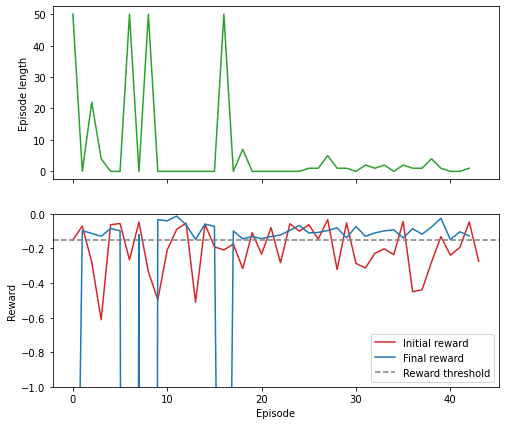

In [10]:
# Plot training evolution
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 7), sharex=True)
axs[0].plot(env.episode_len_log, c="tab:green", label="Episode length")
axs[0].set_ylabel("Episode length")
axs[1].plot(env.initial_reward_log, c="tab:red", label="Initial reward")
axs[1].plot(env.final_reward_log, c="tab:blue", label="Final reward")
axs[1].axhline(env.reward_threshold, c="tab:gray", linestyle="--", label="Reward threshold")
axs[1].set_ylabel("Reward")
axs[1].set_xlabel("Episode")
axs[1].set_ylim(-1.0, 0.0)
axs[1].legend()
plt.show()